In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks

In [3]:
patient = 2
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
# cgmData.dropna()
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")
# print(insulinBasal.table)

In [64]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [65]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append([slope])
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [66]:
# Velocity Computation
window_size = 5
vels = []
for j in range(len(cgmNorm_np)):
    velocities = []
    for i in range(len(cgmNorm_np[j])-window_size):
        velocity = lr(cgmNorm_np[j][i:i+window_size], cgmSeries_np[j][i:i+window_size])
        velocities.append(velocity[0])
    vels.append(velocities)
vels = np.nan_to_num(vels)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [67]:
# Acceleration Computation
accs = []
for j in range(len(vels)):
    accelerations = []
    for i in range(len(vels[j])-window_size):
        acceleration = lr(vels[j][i:i+window_size], cgmSeries_np[j][i+1:i+1+window_size])
        accelerations.append(acceleration[0])
    accs.append(accelerations)
accs = np.nan_to_num(accs)

In [76]:
# Regression Error
reg_window_size = 6
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

[13.08892607]
0.07640046207234263


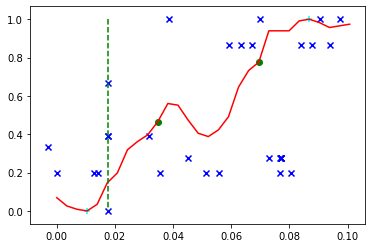

[0.77586207 0.46551724]
[0.16034482 0.27602586]
[0.06945602 0.03472222]


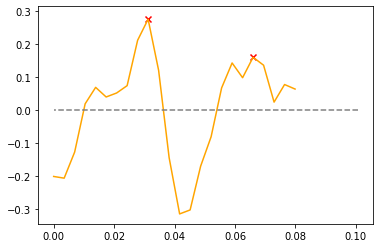

[28.80000027]
0.03472222189884633


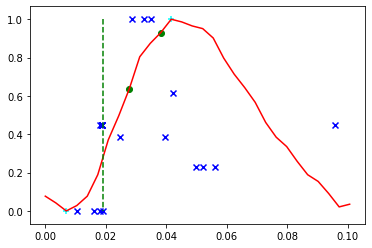

[0.93006993 0.63636364]
[0.17902098 0.22657343]
[0.03819444 0.02777778]


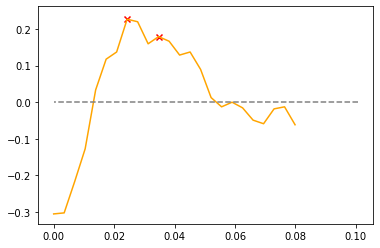

[26.18181847]
0.0381944440305233


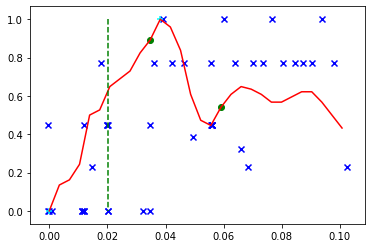

[0.54054054 0.89189189]
[0.21621622 0.51261729]
[0.0590625  0.03472222]


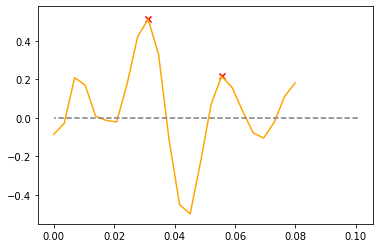

[0.]
0.0


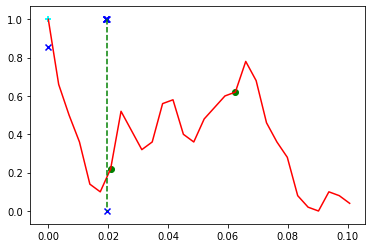

[0.22 0.62]
[0.328      0.43999998]
[0.02083333 0.0625    ]


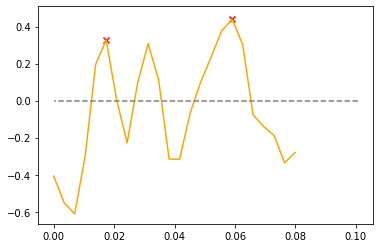

[12.00000006]
0.08333333290647715


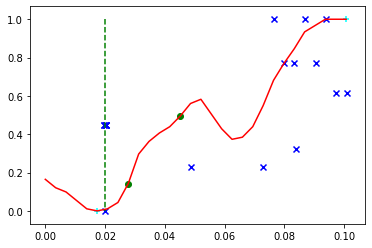

[0.14285714 0.49450549]
[0.16703296 0.26153847]
[0.02777778 0.04513889]


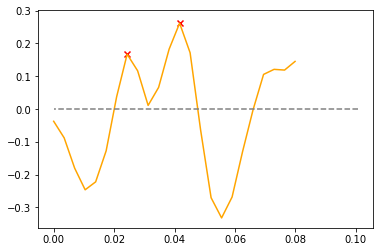

[19.20000007]
0.0520833331393078


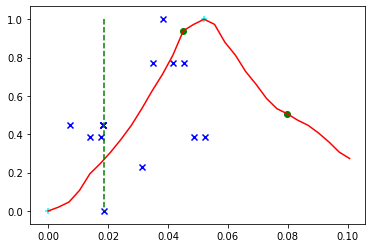

[0.50666667 0.94      ]
[0.03333333 0.29066668]
[0.07988426 0.04513889]


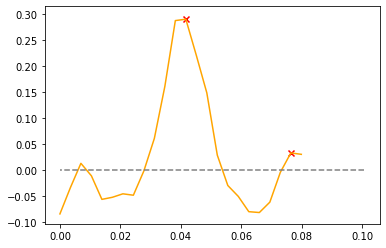

[15.9970376]
0.06251157401129603


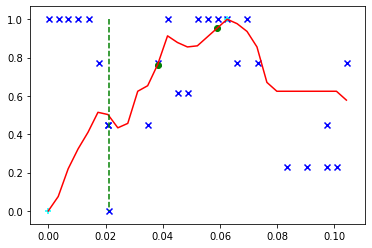

[0.76300578 0.95375723]
[0.2416185  0.29248556]
[0.03820602 0.05903935]


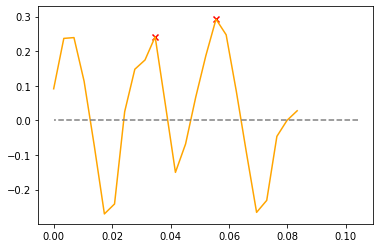

[19.19147032]
0.052106481860391796


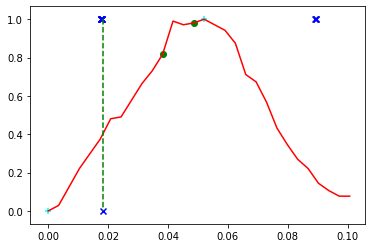

[0.98076923 0.81730769]
[0.19807694 0.25576923]
[0.04863426 0.03821759]


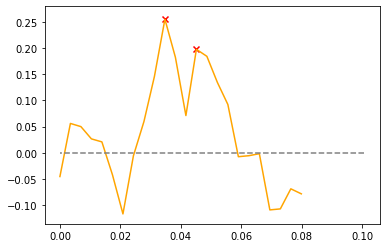

[26.18181855]
0.03819444391410798


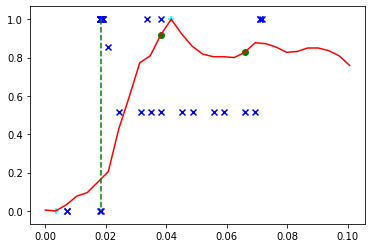

[0.82727273 0.91818182]
[0.10727273 0.27      ]
[0.06597222 0.03819444]


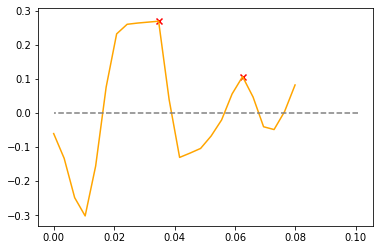

[22.1538461]
0.045138888992369175


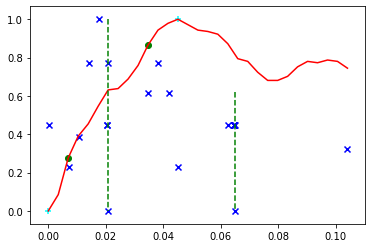

[0.27659574 0.86524823]
[0.17730496 0.21134752]
[0.00694444 0.03472222]


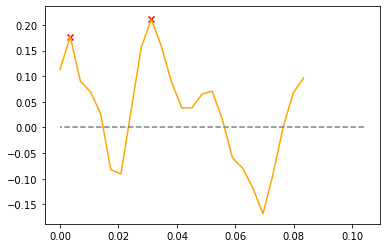

[35.38983262]
0.0138888880610466


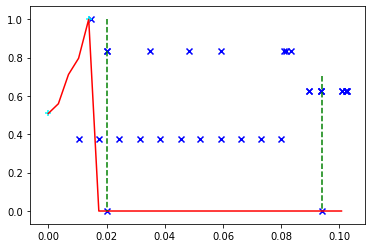

[]
[]
[]


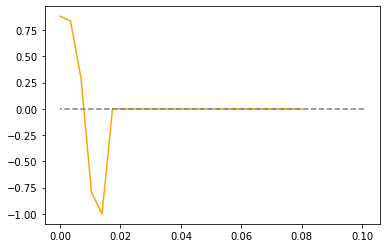

[23.99999982]
0.041666666977107525


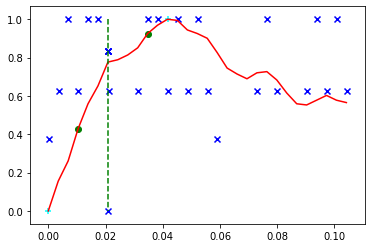

[0.92546584 0.42857143]
[0.17267081 0.19875779]
[0.03472222 0.01041667]


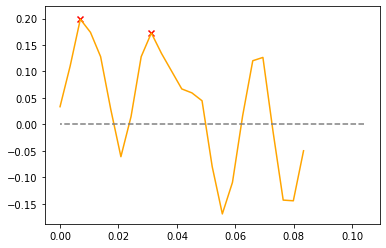

[10.66534996]
0.09376157401129603


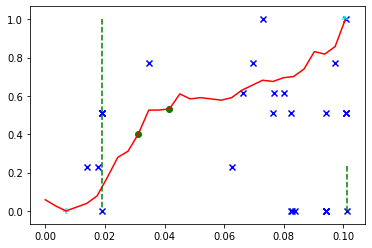

[0.53246753 0.4025974 ]
[0.08959222 0.16363637]
[0.04166667 0.03125   ]


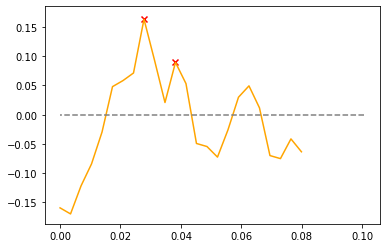

[9.59893343]
0.10417824098840356


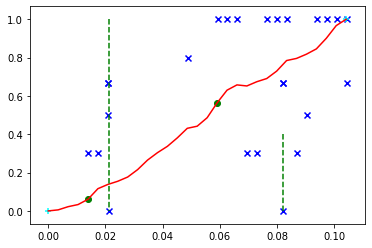

[0.06077348 0.56353591]
[0.0320442  0.11933702]
[0.01388889 0.05903935]


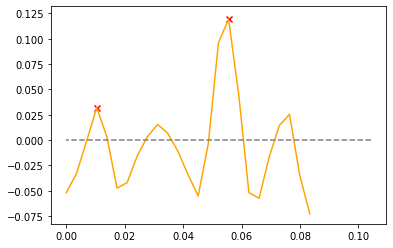

[16.94117641]
0.05902777798473835


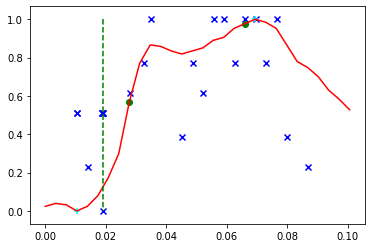

[0.97637795 0.56692913]
[0.18740159 0.50551181]
[0.06597222 0.02777778]


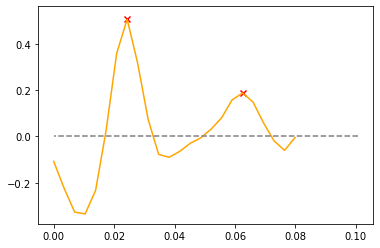

[22.15384616]
0.04513888887595385


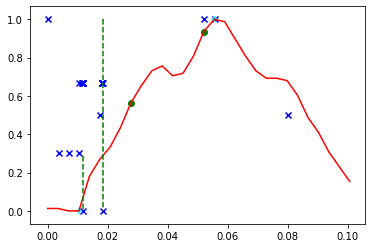

[0.56410256 0.93589744]
[0.23589744 0.36410257]
[0.02777778 0.05208333]


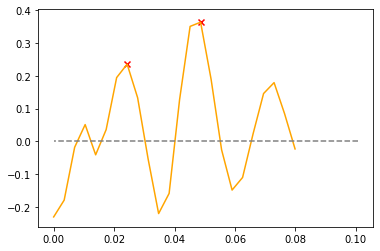

[0.]
0.0


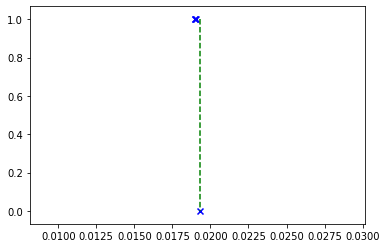

[]
[]
[]


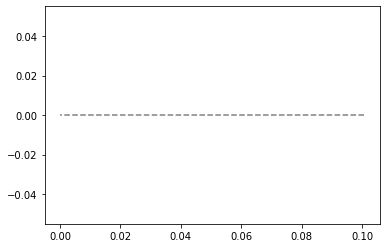

[0.]
0.0


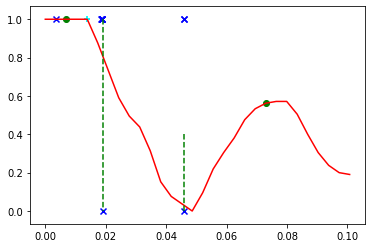

[0.56190476 1.        ]
[0.21904761 0.27428573]
[0.07293981 0.00694444]


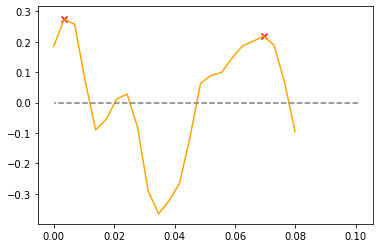

[9.59999997]
0.10416666697710752


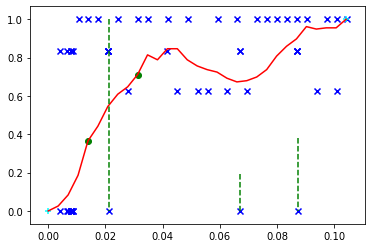

[0.36538462 0.71153846]
[0.14871795 0.16666667]
[0.01388889 0.03125   ]


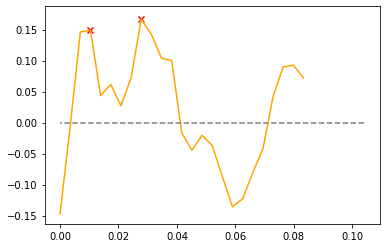

[14.5196674]
0.06597222306299955


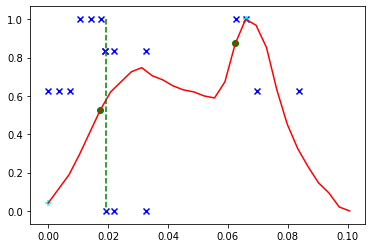

[0.52631579 0.87368421]
[0.18736842 0.68000003]
[0.01736111 0.0625    ]


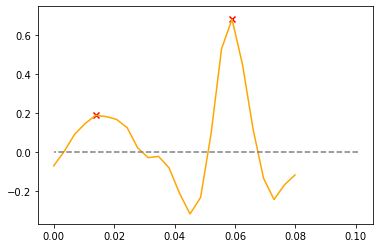

[29.46277114]
0.03126157505903393


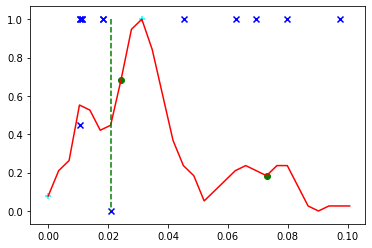

[0.18421053 0.68421053]
[0.18947368 0.92631577]
[0.07292824 0.02431713]


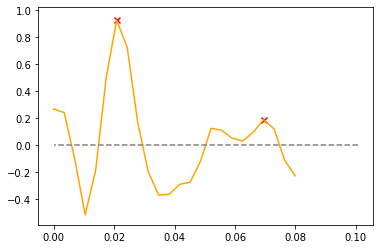

[10.66666667]
0.09375


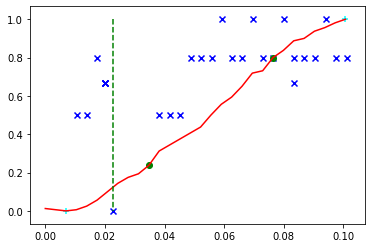

[0.2375 0.8   ]
[0.05624999 0.0575    ]
[0.03472222 0.07638889]


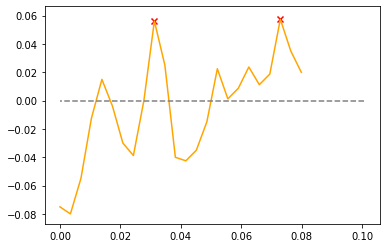

[0.]
0.0


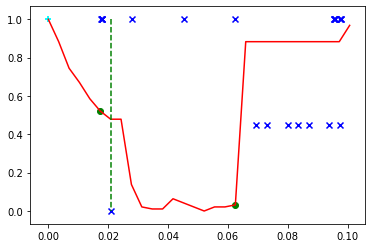

[0.5212766  0.03191489]
[0.19787233 0.86170213]
[0.01736111 0.0625    ]


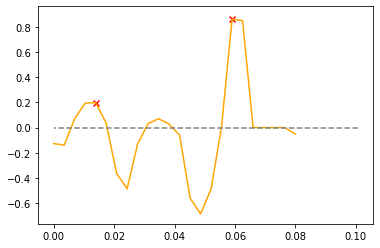

[0.]
0.0


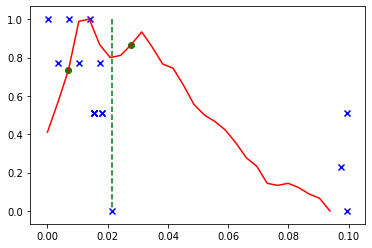

[0.86666667 0.73333333]
[0.24688891 0.54888888]
[0.02777778 0.00694444]


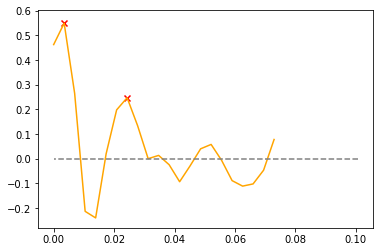

[12.00000004]
0.08333333302289248


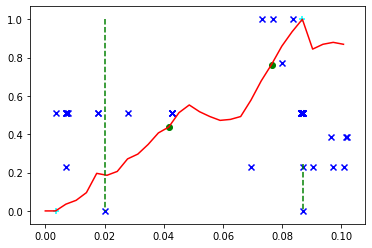

[0.43718593 0.7638191 ]
[0.15879397 0.25125629]
[0.04166667 0.07638889]


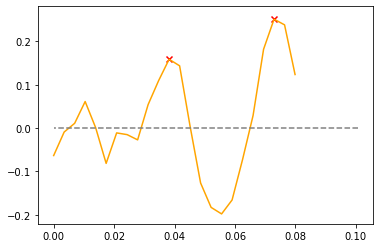

[22.148167]
0.04515046323649585


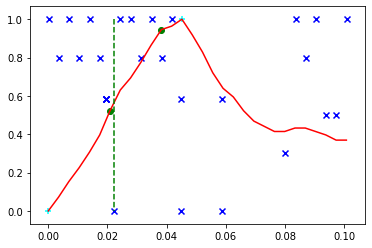

[0.52252252 0.94594595]
[0.06486488 0.28468467]
[0.02084491 0.03820602]


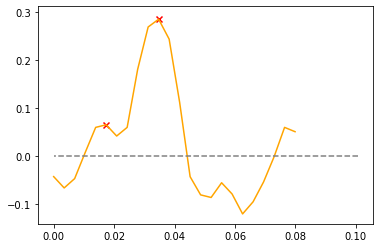

[20.57142862]
0.048611111007630825


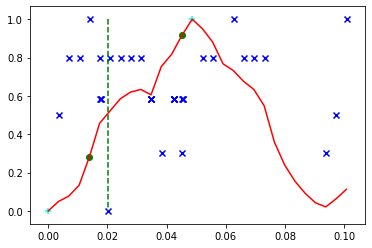

[0.28169014 0.91549296]
[0.24929579 0.3366197 ]
[0.01388889 0.04513889]


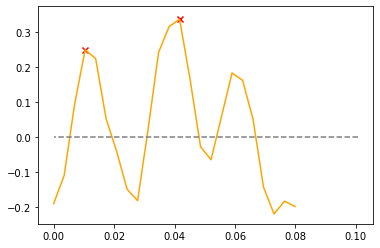

[20.56163746]
0.04863425891380757


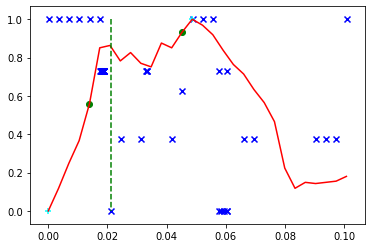

[0.93167702 0.55900621]
[0.28819875 0.53180952]
[0.04516204 0.01391204]


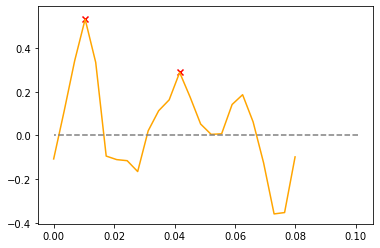

[12.52173913]
0.07986111112404615


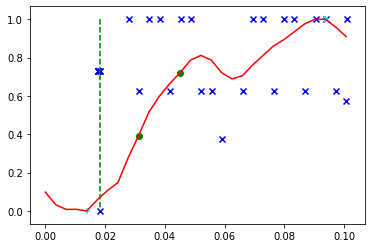

[0.39344262 0.72131148]
[0.11311475 0.20983607]
[0.03125    0.04513889]


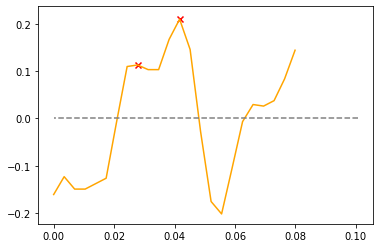

[13.71428563]
0.07291666709352285


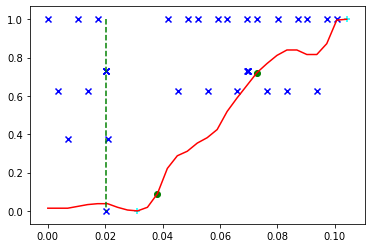

[0.72169811 0.08962264]
[0.11037736 0.13773585]
[0.07291667 0.03819445]


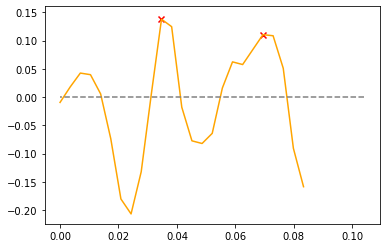

[20.03225792]
0.02777777798473835


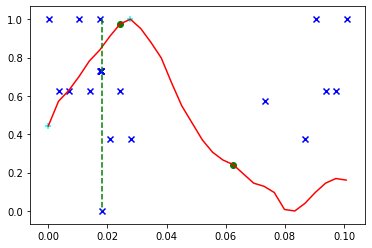

[0.24193548 0.97580645]
[0.01626882 0.27419355]
[0.0625     0.02430556]


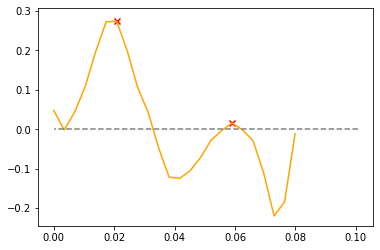

[16.]
0.0625


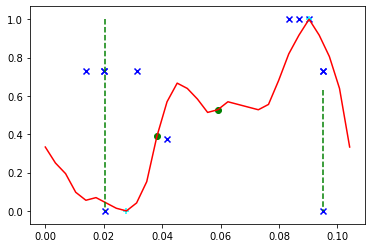

[0.52777778 0.38888889]
[0.05833333 0.51944445]
[0.05902778 0.03819444]


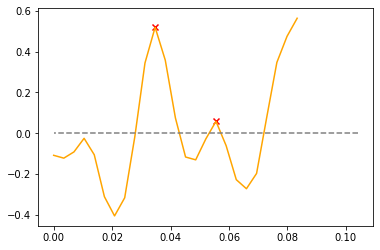

[0.]
0.0


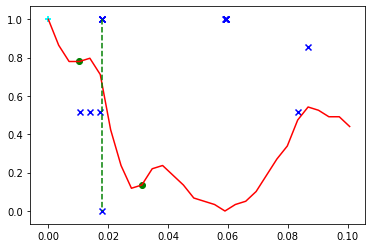

[0.13559322 0.77966102]
[0.21355932 0.41016955]
[0.03125    0.01041667]


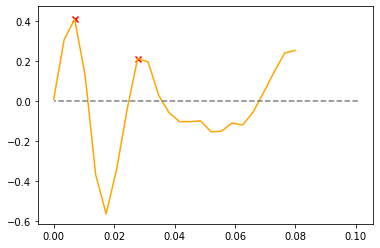

[10.66666667]
0.09375


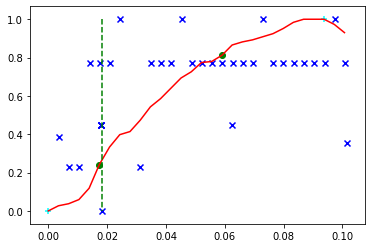

[0.81182796 0.24193548]
[0.05698925 0.11612902]
[0.05902778 0.01736111]


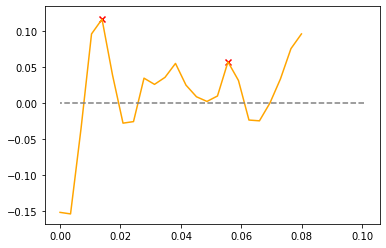

[8.75294133]
0.04166666592936963


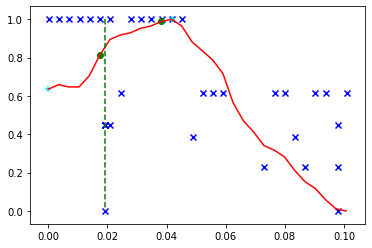

[0.98823529 0.81176471]
[0.15058823 0.15529412]
[0.03819444 0.01736111]


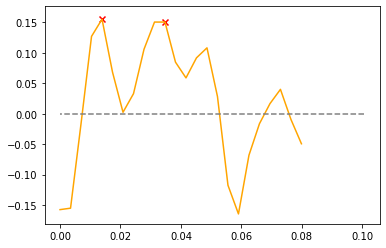

[32.]
0.03125


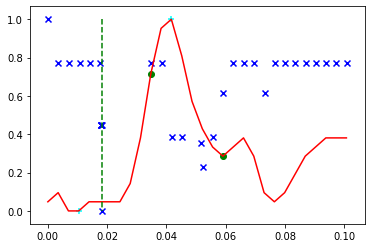

[0.28571429 0.71428571]
[0.23809525 0.96103892]
[0.0590625  0.03472222]


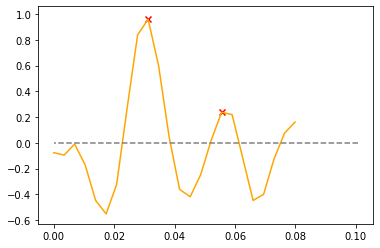

[12.521739]
0.0798611119389534


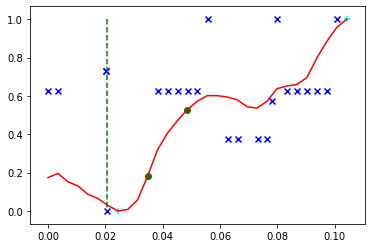

[0.52898551 0.18115942]
[0.11594203 0.14927536]
[0.04861111 0.03472222]


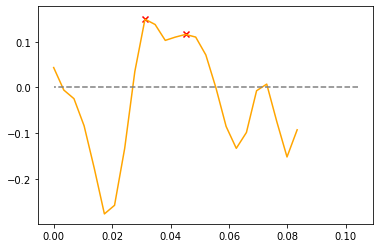

[28.80000036]
0.017361110891215503


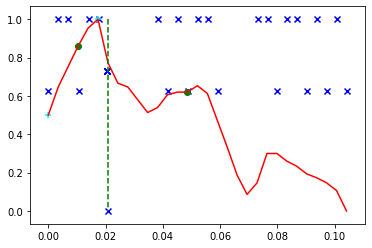

[0.62 0.86]
[0.31733334 0.43333333]
[0.04861111 0.01041667]


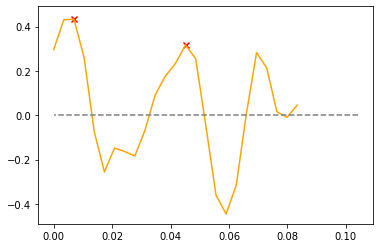

In [78]:
# reading = 0
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
#     plt.figure()
#     plt.plot(cgmSeries_np[i][:-window_size], vels[i], c='blue')
#     plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
#     plt.show()
#     plt.figure()
#     plt.plot(cgmSeries_np[i][:-2*window_size], accs[i], c='pink')
#     plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()